\newpage

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from fancyimpute import SoftImpute
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

We first import the [Chronic Kidney Disease (CKD) dataset](https://www.kaggle.com/datasets/mansoordaku/ckdisease).

In [265]:
df = pd.read_csv('kidney_disease.csv')

## (1) Classification Problem Identification

Problem: Predict if a patient has Chronic Kidney Disease (CKD)

Description: The dataset contains various variables that are commonly used in diagnosing CKD, such as `Age`, `Serum Creatinine`, `Red Blood Cells`, etc.

We can use a variable that shows the presence or absence of CKD by using a binary variable (1 for presence, 0 for absence).

Common evaluation metrics for this classification problem include accuracy, precision and others depending on the specific requirements of the analysis.

Building classification models based on this dataset can develop a tool that can assist healthcare professionals in early detection and diagnosis of CKD, potentially leading to better patient outcomes through timely intervention and treatment.

## (2) Variable Transformation

Here we transform the strings to binary variables.

In [266]:
columns = ['dm', 'cad', 'classification']

for col in columns:
    df[col] = df[col].str.strip()

In [267]:
columns = ['pcv', 'wc', 'rc']

for col in columns:
    df[col] = pd.to_numeric(df[col].str.strip(), errors='coerce')

In [268]:
df['rbc'] = df['rbc'].replace({'abnormal': 0, 'normal': 1})
df['pc'] = df['pc'].replace({'abnormal': 0, 'normal': 1})
df['pcc'] = df['pcc'].replace({'notpresent': 0, 'present': 1})
df['ba'] = df['ba'].replace({'notpresent': 0, 'present': 1})
df['htn'] = df['htn'].replace({'no': 0, 'yes': 1})
df['dm'] = df['dm'].replace({'no': 0, 'yes': 1})
df['cad'] = df['cad'].replace({'no': 0, 'yes': 1})
df['appet'] = df['appet'].replace({'poor': 0, 'good': 1})
df['pe'] = df['pe'].replace({'no': 0, 'yes': 1})
df['ane'] = df['ane'].replace({'no': 0, 'yes': 1})
df['classification'] = df['classification'].replace({'notckd': 0, 'ckd': 1})

We converted categorical variables to numeric representations to ensure a clear and uniform format. This approach enhances clarity and is more suitable for analysis later.

## (3) Dataset Overview

In [269]:
df_orig = pd.read_csv('kidney_disease.csv')
df_orig.head(10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44,6900,5,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [270]:
df_orig.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [271]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [272]:
df_orig.shape

(400, 26)

In [273]:
df_orig.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

The dataset contains of 400 rows and 26 columns with each row representing an observation and each column representing a feature. The data types of the features range from integer and float for numerical variables to object for categorical variables. Numeric features include `age`, `bp`, `sg`, `al`, `su`, `bgr`, `bu`, `sc`, `sod`, `pot`, `hemo`, `pcv`, `wc`, and `rc` and categorical features include `rbc`, `pc`, `pcc`, `ba`, `htn`, `dm`, `cad`, `appet`, `pe`, `ane`, and `classification`. The number of null values in the dataset ranges from 0 to 152 across different features, with `rbc` having the highest null count at 152 and `appet`, `pe`, `ane`, and `classification` having the lowest null counts, with zero or only one missing value. All variables were converted to float64 in question 2 for variable transformation.

## (4) Association Between Variables

We remove the categorical variables as correlation coefficients are only meaningful for numeric data. Categorical variables cannot be directly used to calculate correlations with other variables. By removing these variables, we ensure that the resulting correlations accurately reflect the relationships between numeric variables, providing meaningful insights into the dataset's structure.

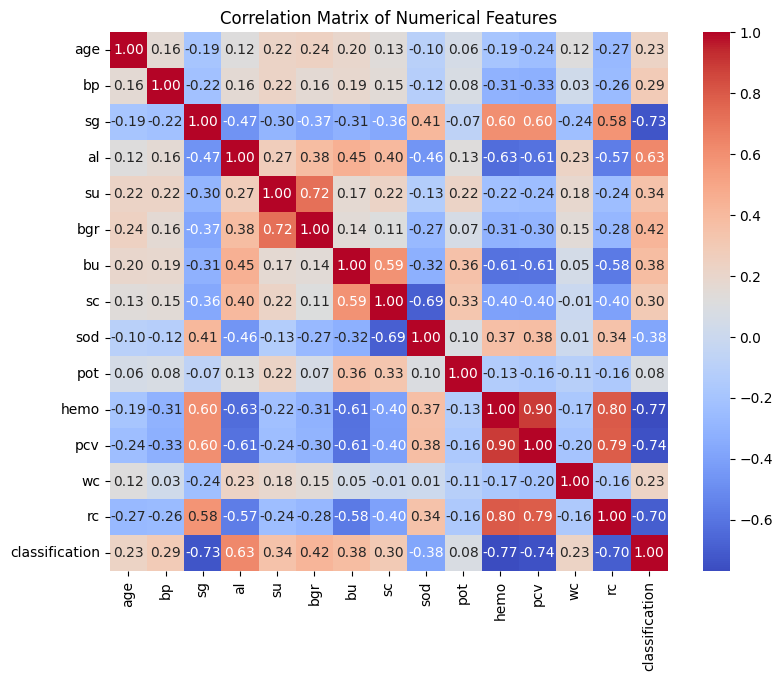

In [274]:
remove_col = ['id', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
df_drop = df.drop(columns=remove_col)

plt.figure(figsize=(9, 7))
sns.heatmap(df_drop.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

 The correlation matrix shows how different numerical features relate to each other and to the 'classification' label. High positive correlations, like the strong link between 'pcv' and 'hemo' at 0.90, suggest they often change together in the same direction. The second-highest positive correlation is between 'hemo' and 'rc' at 0.80 which indicates a strong connection between hemoglobin and red blood cell count. On the other hand, strong negative correlations, such as -0.77 between 'hemo' and 'classification,' mean they tend to move in opposite directions. The second-lowest negative correlation is between 'pcv' and 'classification' at -0.74 which suggests an inverse relationship between packed cell volume and the classification of chronic kidney disease. These insights help in understanding how different factors interact and influence the target variable.

## (5) Missing Value Analysis and Handling


In [275]:
df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [276]:
df_imputed = SoftImpute().fit_transform(df)

[SoftImpute] Max Singular Value of X_init = 152770.364368
[SoftImpute] Iter 1: observed MAE=20.241834 rank=2
[SoftImpute] Iter 2: observed MAE=20.152034 rank=2
[SoftImpute] Iter 3: observed MAE=20.154375 rank=2
[SoftImpute] Iter 4: observed MAE=20.154001 rank=2
[SoftImpute] Iter 5: observed MAE=20.153452 rank=2
[SoftImpute] Iter 6: observed MAE=20.152933 rank=2
[SoftImpute] Iter 7: observed MAE=20.152431 rank=2
[SoftImpute] Iter 8: observed MAE=20.151937 rank=2
[SoftImpute] Iter 9: observed MAE=20.151451 rank=2
[SoftImpute] Iter 10: observed MAE=20.150977 rank=2
[SoftImpute] Iter 11: observed MAE=20.150508 rank=2
[SoftImpute] Iter 12: observed MAE=20.150044 rank=2
[SoftImpute] Iter 13: observed MAE=20.149593 rank=2
[SoftImpute] Iter 14: observed MAE=20.149158 rank=2
[SoftImpute] Iter 15: observed MAE=20.148732 rank=2
[SoftImpute] Iter 16: observed MAE=20.148315 rank=2
[SoftImpute] Iter 17: observed MAE=20.147903 rank=2
[SoftImpute] Iter 18: observed MAE=20.147496 rank=2
[SoftImpute] It

In [277]:
df = pd.DataFrame(df_imputed, columns=df.columns)
df.head(10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0.0,48.0,80.000000,1.020,1.0,0.0,0.655332,1.000000,0.0,0.0,...,44.0,7800.000000,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,7.0,50.000000,1.020,4.0,0.0,0.502812,1.000000,0.0,0.0,...,38.0,6000.000000,2.807183,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0,62.0,80.000000,1.010,2.0,3.0,1.000000,1.000000,0.0,0.0,...,31.0,7500.000000,3.595939,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,3.0,48.0,70.000000,1.005,4.0,0.0,1.000000,0.000000,1.0,0.0,...,32.0,6700.000000,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,4.0,51.0,80.000000,1.010,2.0,0.0,1.000000,1.000000,0.0,0.0,...,35.0,7300.000000,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,5.0,60.0,90.000000,1.015,3.0,0.0,0.655144,0.591149,0.0,0.0,...,39.0,7800.000000,4.400000,1.0,1.0,0.0,1.0,1.0,0.0,1.0
6,6.0,68.0,70.000000,1.010,0.0,0.0,0.030968,1.000000,0.0,0.0,...,36.0,176.305043,0.152020,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,7.0,24.0,54.957462,1.015,2.0,4.0,1.000000,0.000000,0.0,0.0,...,44.0,6900.000000,5.000000,0.0,1.0,0.0,1.0,1.0,0.0,1.0
8,8.0,52.0,100.000000,1.015,3.0,0.0,1.000000,0.000000,1.0,0.0,...,33.0,9600.000000,4.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0
9,9.0,53.0,90.000000,1.020,2.0,0.0,0.000000,0.000000,1.0,0.0,...,29.0,12100.000000,3.700000,1.0,1.0,0.0,0.0,0.0,1.0,1.0


## (6) Outlier Analysis

In [278]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

outliers.sum()

244

We identified 244 outliers, but we have chosen not to remove them because this dataset only contains 400 observations, which is relatively small. Therefore, we have decided to keep the dataset as it is.

## (7) Sub-group Analysis

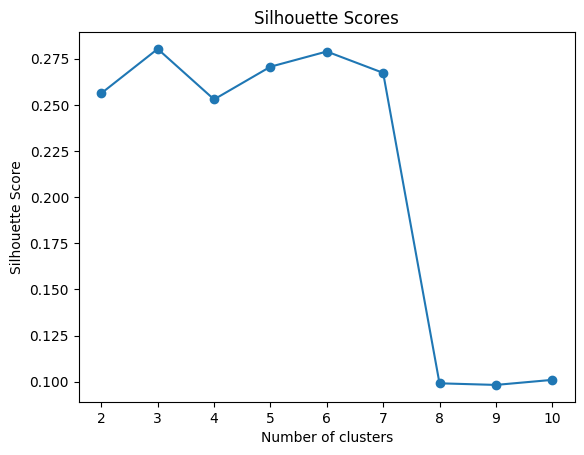

In [279]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()


From the above graph, we can see that `k=3` and `k=6` has the highest silhouette scores, so we will compare the two k-values.

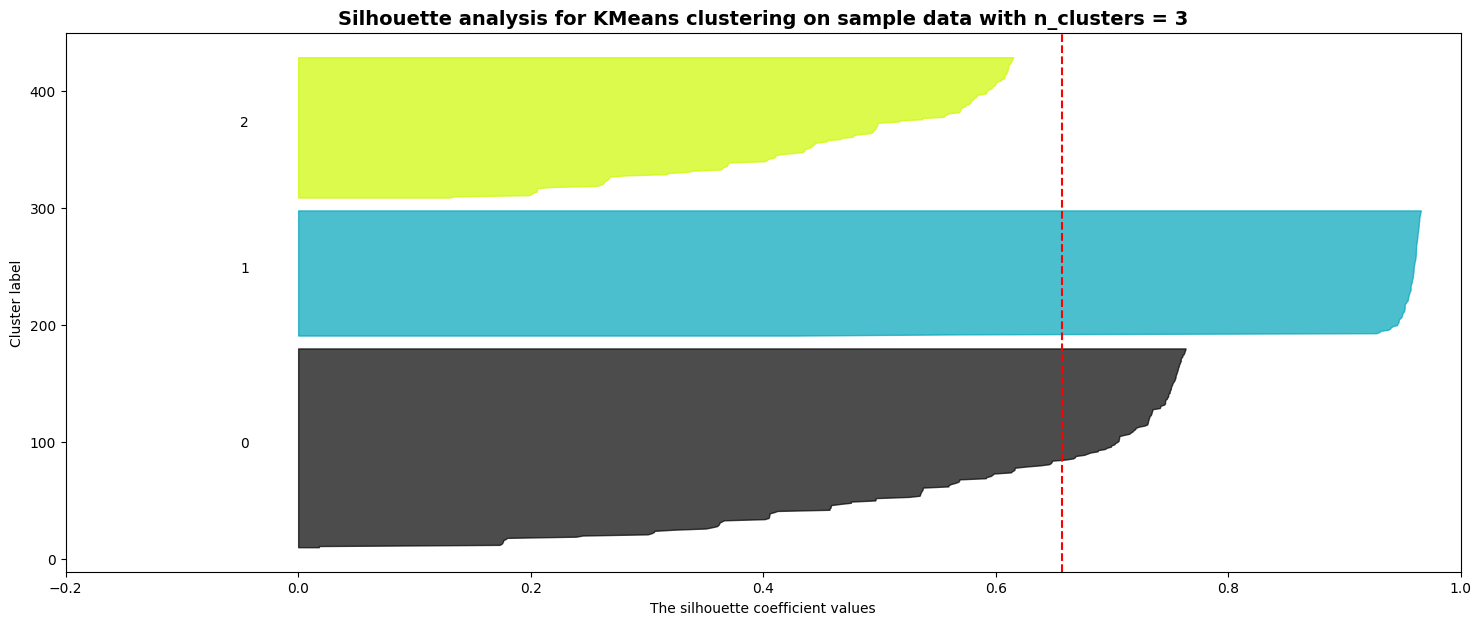

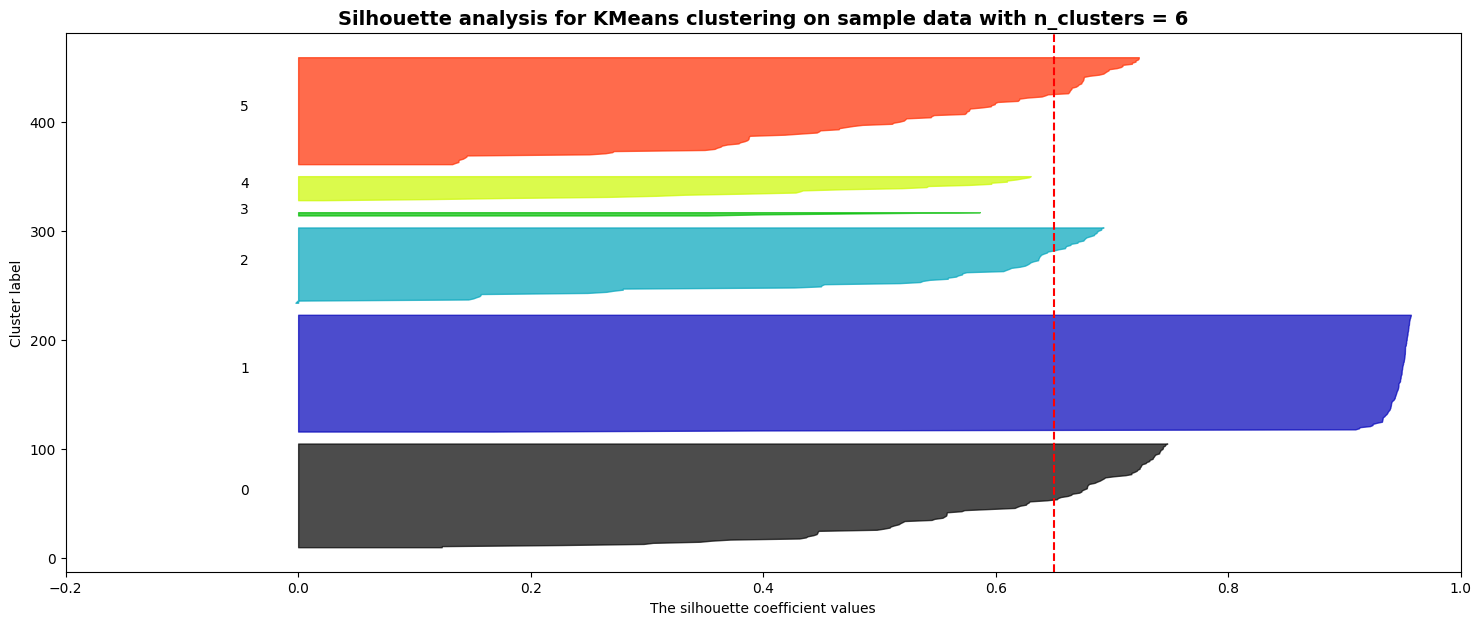

In [280]:
range_n_clusters = [3,6]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, n_init=20, random_state=0)
    cluster_labels_km = km.fit_predict(X)
    silhouette_avg_km = silhouette_score(X, cluster_labels_km)
    sample_silhouette_values = silhouette_samples(X, cluster_labels_km)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.2, 1])

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            y=np.arange(y_lower, y_upper),
            x1=0,
            x2=ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  
    
    ax1.set_title("The silhouette plot for K = {}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

We think `k=3` is a better k-value because it has a higher overall silhouette score and the clusters are of similar sizes.

## (8) Data Splitting

In [281]:
X = df.drop(columns=['classification'])
y = df['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## (9) Classifier Choices

Logistic Regression provides a coefficient for each feature, which allows us to understand the impact of each feature on the predicted outcome. In this case, the predicted outcome is the presence or absence of CKD. Logistic Regression assumes a linear relationship between the independent variables and the log-odds of the outcome. This assumption is usually reasonable for many classification problems, including medical diagnosis like CKD. This method tends to perform well on datasets with fewer features and observations, making it suitable for datasets like ours. 

Another choice is the K-Nearest Neighbours (KNN) Classification. KNN can be effective in predicting the presence or absence of Chronic Kidney Disease (CKD) by considering the similarity of each patient's features to those of patients with known CKD status. It makes decisions based on the characteristics of nearby data points. KNN is suitable for our dataset as it works well wtih moderate number of observations and features. However, it's essential to choose the appropriate value of 'k' (number of neighbors) and the right distance metric for our dataset. We will need to explore different k-values to find the optimal value that maximizes the model's performance.

## (10) Performance Metrics

To compare the performance of the classifiers, we can use the following two metrics:

Accuracy measures the overall correctness of the model's predictions. It calculates the proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances. Accuracy is a widely used metric for evaluating classification models, especially when the class distribution is balanced. However, it may not be suitable for imbalanced datasets as it can be misleading.

F1 score is the harmonic mean of precision and recall. Precision measures the proportion of true positive predictions out of all positive predictions made by the model, while recall measures the proportion of true positive predictions out of all actual positive instances in the dataset. The F1 score provides a balance between precision and recall, making it useful for evaluating models in imbalanced datasets.

## (11) Feature Selection/Extraction

We choose to enhance the Random Forest Classifier. We can implement feature selection techniques as they help us focus on the most relevant information in our dataset. It makes it easier for our model to learn and make predictions, which can lead to better overall performance. One common approach for feature selection with Random Forest Classifier is to use feature importance ranking. Random Forest Classifier assigns importance scores to each feature based on how much they contribute to reducing impurity in the decision trees. We can then select the top-ranked features for training the model.

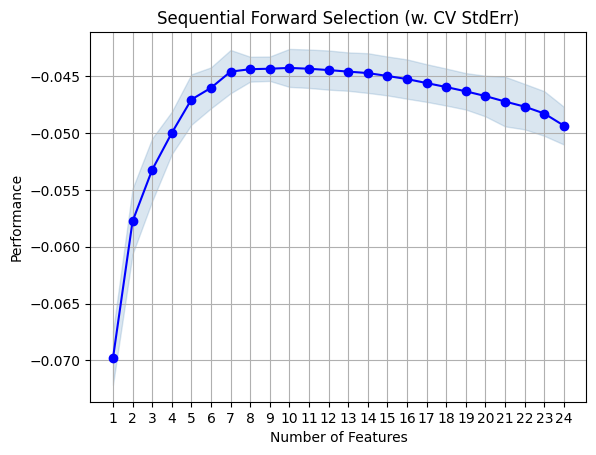

In [282]:
f_m = LinearRegression()

sfs = SFS(
    f_m,
    k_features=(1,24),
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=5
    )
sfs = sfs.fit(X_train, y_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. CV StdErr)')
plt.grid()
plt.show()

In [283]:
X_train.columns[list(sfs.k_feature_idx_)]

Index(['id', 'al', 'rbc', 'bgr', 'sod', 'hemo', 'wc', 'rc', 'htn', 'dm'], dtype='object')

In [284]:
sel_col = X_train.columns[list(sfs.k_feature_idx_)]
X_train_sfs = X_train[sel_col]
X_test_sfs = X_test[sel_col]
sfs_m = LinearRegression()
sfs_m.fit(X_train_sfs, y_train)
sfs_test = sfs_m.predict(X_test_sfs)
np.sqrt(metrics.mean_squared_error(y_test, sfs_test))

0.1866437608459299

## (12) Classifier Comparison

In [285]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
knn_pred = knn_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

print("Logistic Regression:")
print("Accuracy:", lr_accuracy)
print("F1 Score:", lr_f1)
print()
print("KNN Classifier:")
print("Accuracy:", knn_accuracy)
print("F1 Score:", knn_f1)

Logistic Regression:
Accuracy: 0.9416666666666667
F1 Score: 0.9481481481481482

KNN Classifier:
Accuracy: 0.9333333333333333
F1 Score: 0.9411764705882353


In comparing the two classifiers, the Logistic Regression model achieved an accuracy of 94.17% and an F1 score of 94.81% on the test set, which demonstrated its balanced performance between precision and recall. This means it correctly classified 94.17% of instances while maintaining a good balance between true positives and avoiding false positives and false negatives. On the other hand, the KNN Classifier achieved an accuracy of 93.33% and an F1 score of 94.12%. Although both models performed well, the Logistic Regression model showed slightly higher accuracy and F1 score, indicating its effectiveness in this classification task.

## (13) Interpretable Classifier Insight

In [286]:
pred_var = ['bp', 'sg', 'al', 'su', 'bgr', 'hemo', 'appet']
design_matrix = df[pred_var]

x_train, x_test, y_train, y_test = train_test_split(design_matrix, y,
test_size=0.25,
random_state=0,
stratify=y)
 
logit_model = sm.Logit(y_train, sm.add_constant(x_train))
result = logit_model.fit()
 
result.summary()

Optimization terminated successfully.
         Current function value: 0.180062
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         classification   No. Observations:                  300
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            7
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.7275
Time:                        23:22:06   Log-Likelihood:                -54.019
converged:                       True   LL-Null:                       -198.21
Covariance Type:            nonrobust   LLR p-value:                 1.824e-58
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8715      4.356      1.807      0.071      -0.666      16.409
bp             0.0372      0.020      1.901      0.057      -0.001       0.075
sg            -2.3574      1.844     -1.278      0.201      -5.972       1.257
al             3.2551      0.806      4.039      0.000       1.676       4.835
su             0.7089      0.590      1.202      0.229      -0.447       1.865
bgr            0.0099      0.007      1.396      0.163      -0.004       0.024
hemo          -0.4404      0.107     -4.120      0.000      -0.650      -0.231
appet         -4.9418      3.367     -1.468      0.142     -11.541       1.657
==============================================================================

Possibly complete quasi-separation: A fraction 0.26 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The Logistic Regression analysis reveals insights into the importance of predictor variables in classifying CKD. One of the key finding is the significant influence of variables such as albumin (`al`), hemoglobin (`hemo`) and blood pressure (`bp`) on CKD classification. Higher levels of albumin and blood sugar (`su`) are associated with an increased likelihood of CKD, while higher hemoglobin levels are linked to a lower likelihood of CKD. We can also see that variables such as albumin (`al`) and hemoglobin (`hemo`) exhibit p-values close to zero, indicating a strong statistical significance in predicting CKD. Conversely, variables like specific gravity (`sg`) and appetite (`appet`) have higher p-values which suggests a lower level of significance. These insights were derived from the logistic regression coefficients and p-values. The model's pseudo R-squared value of about 0.7275 indicates that these factors explain around 72.75% of CKD variability based on the chosen predictors.

## (14) [Bonus]

## (15) Team Contribution

Both of us (Akshita and Louise) met up three times and worked on this assignment together. Prior to the meetings, we reviewed our class notes to ensure a solid grasp of the content and material. We shared a Jupyter notebook file and regularly exchanged it to take turns writing the code. We also provided assistance to one another whenever needed throughout the assignment.

## (16) Link

https://github.com/louisecyx/3da3-A6.git